In [ ]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import PIL
from glob import glob
import copy

from dataset.dataset_unet import mask2data
from utils.mask_functions import rle2mask

train_fname_list = glob('../data/processed/train/*')
test_fname_list = glob('../data/processed/test/*')
print('how many images in trainset folder: ', len(train_fname_list))
print('how many images in testset folder: ', len(test_fname_list))

np.random.seed(2018)

mask_data = mask2data()
def get_mask(fname, mask_data):
    img_id = fname.split('/')[-1][:-4]
    try:
        rle = [m for m in mask_data if m['img_id']==img_id][0]['masks'][0]
        return rle2mask(rle, 1024, 1024).T
    except:
        return np.zeros((1024, 1024))
print('how many masks in trainset: ', len(mask_data))

%matplotlib inline

## 图片读取工具
- Matplotlib
- OpenCV
- PIL (Python Image Library)

In [9]:
fname = np.random.choice(train_fname_list, 1)[0]
print(fname)

../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.2175.1517875171.495418.png


**Matplotlib**

<class 'numpy.ndarray'>
(1024, 1024)
0.0 1.0


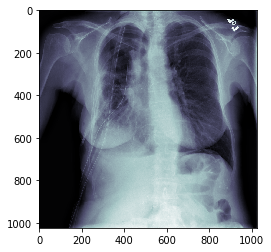

In [3]:
img = plt.imread(fname)
print(type(img))
print(img.shape)
print(img.min(), img.max())
fig = plt.imshow(img, cmap=plt.cm.bone)

**OpenCV**

<class 'numpy.ndarray'>
(1024, 1024)
0 255


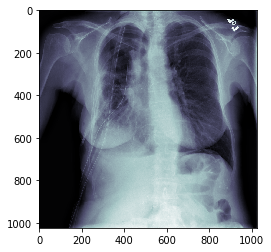

In [4]:
img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
print(type(img))
print(img.shape)
print(img.min(), img.max())
fig = plt.imshow(img, cmap=plt.cm.bone)

**PIL**

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'numpy.ndarray'>
(1024, 1024)
0 255


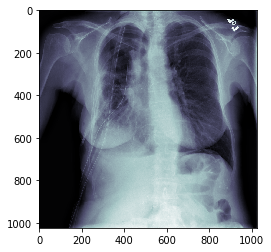

In [5]:
img = PIL.Image.open(fname)
print(type(img))
img = np.asarray(img)
print(type(img))
print(img.shape)
print(img.min(), img.max())
fig = plt.imshow(img, cmap=plt.cm.bone)

## 数据集可视化
- 在图上画出Mask
- 同时展示20张图片

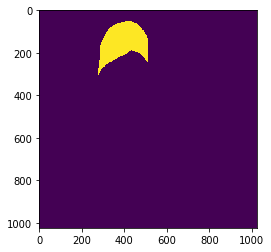

In [6]:
mask = get_mask(fname, mask_data)
plt.imshow(mask)

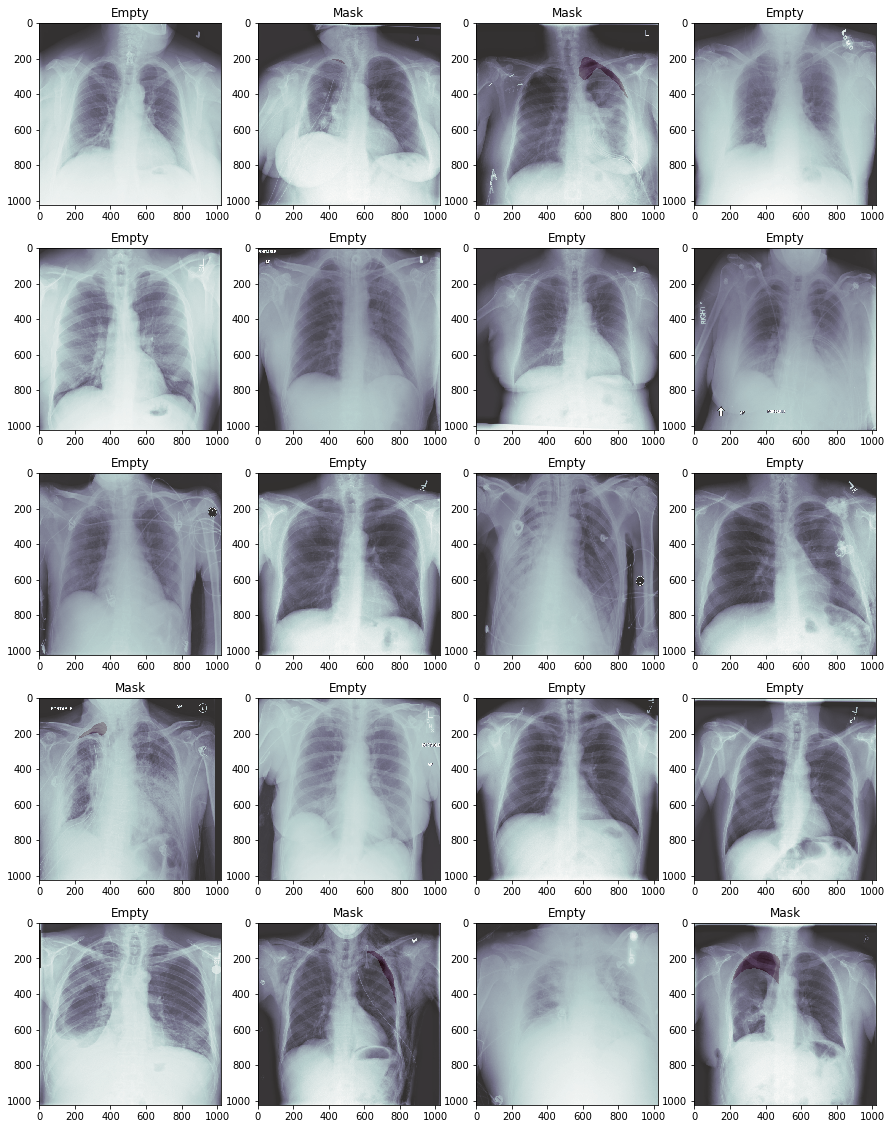

In [3]:
random_image_list = np.random.choice(train_fname_list, 20)

visualize_mask = True

## visualize batch of images
fig = plt.figure(figsize=(15, 20))
for idx, img_fname in enumerate(random_image_list):
    img = plt.imread(img_fname)
    ax = fig.add_subplot(5, 4, idx+1)
    plt.imshow(img, plt.cm.bone)
    
    if visualize_mask:
        mask = get_mask(img_fname, mask_data)
        plt.imshow(mask, alpha=0.2, cmap="Reds")
        if mask.sum()>0:
            plt.title('Mask')
        else:
            plt.title('Empty')

## 3通道图像 vs 1通道图像
- 1-通道图片: Grayscale，黑白
- 3-通道图片: RGB，彩色
- 1通道-->3通道图片转换

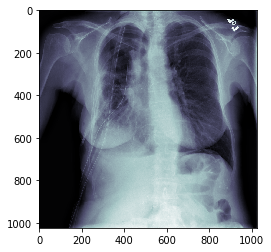

In [10]:
img = plt.imread(fname)
fig = plt.imshow(img, cmap=plt.cm.bone)

In [39]:
new_img = img.reshape(img.shape[0], img.shape[1], 1)
new_img.shape

(1024, 1024, 1)

In [40]:
mean=[0.485, 0.456, 0.406]
std =[0.229, 0.224, 0.225]
img_three_channel = np.concatenate([
                                    (new_img-mean[0])/std[0],
                                    (new_img-mean[1])/std[1],
                                    (new_img-mean[2])/std[2],
                                   ], axis=2)
img_three_channel = np.clip(img_three_channel, 0, 1)
img_three_channel.shape

(1024, 1024, 3)

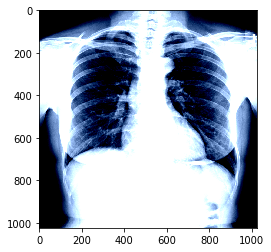

In [41]:
fig = plt.imshow(img_three_channel, cmap=plt.cm.bone)

## 图像运算
#### 工具：
1. Numpy
2. OpenCV

#### 操作：
- 翻转
- 旋转
- 亮度调节
- 透视变换
- 添加遮罩
- 剪切

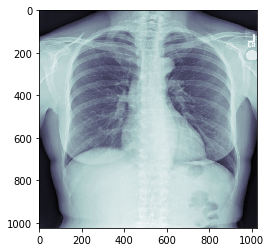

In [42]:
plt.imshow(img, cmap=plt.cm.bone)

In [43]:
# 矩阵
print(img.shape)
img

(1024, 1024)


array([[0.19607843, 0.19607843, 0.2       , ..., 0.27450982, 0.27450982,
        0.27450982],
       [0.21568628, 0.21568628, 0.21568628, ..., 0.26666668, 0.27058825,
        0.27058825],
       [0.21568628, 0.21568628, 0.21960784, ..., 0.2509804 , 0.25490198,
        0.25490198],
       ...,
       [0.2       , 0.20392157, 0.20784314, ..., 0.16862746, 0.16470589,
        0.16470589],
       [0.2       , 0.20392157, 0.20784314, ..., 0.16862746, 0.16862746,
        0.16862746],
       [0.20392157, 0.20392157, 0.20392157, ..., 0.16862746, 0.17254902,
        0.16862746]], dtype=float32)

#### 整体操作

Text(0.5,1,'flip lr')

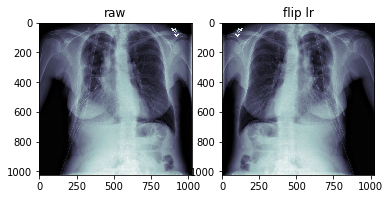

In [91]:
## 左右翻转
#img_flip_lr = img[:, ::-1]
img_flip_lr = cv2.flip(img, 1)

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_flip_lr, cmap=plt.cm.bone)
ax1.set_title('flip lr')

Text(0.5,1,'flip ud')

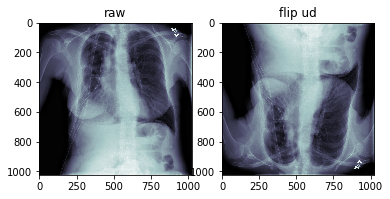

In [94]:
## 上下翻转
img_flip_ud = img[::-1, :]
#img_flip_ud = cv2.flip(img, 0)

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_flip_ud, cmap=plt.cm.bone)
ax1.set_title('flip ud')

Text(0.5,1,'rotate')

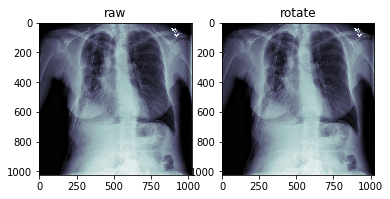

In [12]:
## （逆时针）旋转90"、180"、270"、360"
#img_rot = np.rot90(img, 1)
#img_rot = np.rot90(img, 2)
#img_rot = np.rot90(img, 3)
img_rot = np.rot90(img, 4)

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_rot, cmap=plt.cm.bone)
ax1.set_title('rotate')

Text(0.5,1,'bright')

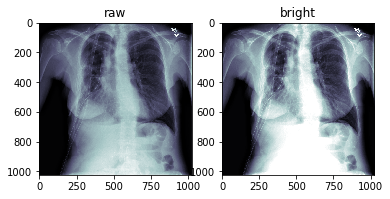

In [13]:
## 亮度调节
img_bright = img + 0.25 #+-0.25
img_bright = np.clip(img_bright, 0, 1)

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_bright, cmap=plt.cm.bone)
ax1.set_title('bright')

Text(0.5,1,'perspective transform')

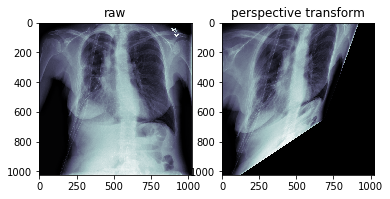

In [14]:
## 透视变换
def do_perspective_transform(image):
    pts1 = np.float32([[200, 200], [800, 200], [200, 800], [800, 800]])
    #pts2 = np.float32([[350, 350], [950, 350], [350, 850], [850, 850]])
    pts2 = np.float32([[100, 300], [750, 100], [100, 900], [600, 600]])
    #pts2 = np.float32([[50, 50], [750, 150], [150, 750], [950, 950]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    image = cv2.warpPerspective(image, M, image.shape)
    return image

img_perspective = do_perspective_transform(img)

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_perspective, cmap=plt.cm.bone)
ax1.set_title('perspective transform')

#### 局部操作

614 226


Text(0.5,1,'add mask')

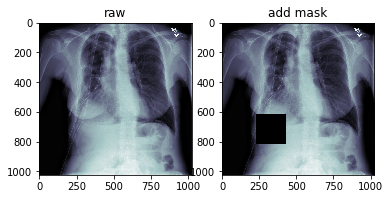

In [15]:
## 局部操作一：添加遮罩
mask = np.zeros((200, 200))
#mask = np.random.random(size=(200, 200))
x, y = np.random.randint(0, 700), np.random.randint(0, 700)
print(x, y)
img_copy = copy.deepcopy(img)
img_copy[x:x+200, y:y+200] = mask


fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_copy, cmap=plt.cm.bone)
ax1.set_title('add mask')

Text(0.5,1,'crop and pad')

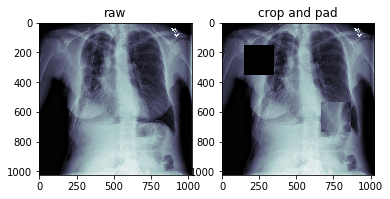

In [16]:
## 局部操作二：剪切一个正方形，粘贴到其他位置(x0,y0)-->(x1,y1)
x0, y0 = np.random.randint(0, 700), np.random.randint(0, 700)
x1, y1 = np.random.randint(0, 700), np.random.randint(0, 700)
crop = img[x0:x0+200, y0:y0+200]
img_copy = copy.deepcopy(img)
img_copy[x1:x1+200, y1:y1+200] = crop
img_copy[x0:x0+200, y0:y0+200] = 0

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(img, cmap=plt.cm.bone)
ax0.set_title('raw')
ax1.imshow(img_copy, cmap=plt.cm.bone)
ax1.set_title('crop and pad')

#### 练习：组合起来？

In [ ]:
## 将两种以上操作同时作用在原图上，看看出现什么效果



## 训练数据集准备
- 工具sklearn
- 随机切分
- stratification

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

#### 先讲一个机器学习的例子

In [23]:
X, y = make_classification(n_samples=100, n_features=4, n_classes=2)
X.shape, y.shape

((100, 4), (100,))

In [19]:
train_index, valid_index = train_test_split(list(range(X.shape[0])), test_size=0.1, random_state=2019)

X_train, y_train = X[train_index, :], y[train_index]
X_valid, y_valid = X[valid_index, :], y[valid_index]

X_train.shape, X_valid.shape

((90, 4), (10, 4))

In [20]:
train_index

[42,
 19,
 18,
 98,
 69,
 60,
 9,
 70,
 63,
 43,
 20,
 4,
 77,
 97,
 0,
 35,
 39,
 32,
 23,
 49,
 30,
 44,
 86,
 56,
 41,
 36,
 76,
 14,
 68,
 93,
 2,
 22,
 85,
 81,
 40,
 47,
 25,
 95,
 34,
 99,
 90,
 64,
 84,
 67,
 59,
 75,
 38,
 78,
 79,
 17,
 82,
 27,
 26,
 52,
 3,
 7,
 55,
 8,
 57,
 58,
 53,
 33,
 61,
 51,
 11,
 10,
 54,
 65,
 92,
 89,
 21,
 28,
 94,
 5,
 50,
 80,
 91,
 83,
 71,
 48,
 16,
 12,
 15,
 29,
 24,
 62,
 88,
 37,
 31,
 72]

#### 图像数据集，用图片文件名作为ID，切分为两个包含ID集合的训练集、验证集

In [25]:
train_fnames, valid_fnames = train_test_split(train_fname_list, test_size=0.1, random_state=2019)
print('数据集图片数量： ', len(train_fname_list))
print('训练集图片数量：%d，验证集图片数量：%d'%(len(train_fnames), len(valid_fnames)))

数据集图片数量：  10712
训练集图片数量：9640，验证集图片数量：1072


In [26]:
train_fnames[:10]

['../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.10295.1517875223.23166.png',
 '../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.5035.1517875186.70725.png',
 '../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.4891.1517875185.295864.png',
 '../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.4172.1517875181.498459.png',
 '../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.32112.1517875158.497648.png',
 '../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.11004.1517875229.359292.png',
 '../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.577.1517875163.520080.png',
 '../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.31641.1517875156.38707.png',
 '../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.3895.1517875180.10946.png',
 '../data/processed/train/1.2.276.0.7230010.3.1.4.8323329.5354.1517875187.737031.png']

#### stratification切分

In [6]:
sex = np.random.choice([0,1], size=len(y), p=[0.2, 0.8])
sex[:10]

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1])

In [7]:
train_index, valid_index = train_test_split(list(range(X.shape[0])), test_size=0.1, random_state=2019, 
                                            stratify=sex)

#### 图像数据里怎么用好stratification切分？

In [28]:
## 根据每张图片中mask个数切分，0/1，使训练集和验证集的0/1分布尽量接近
train_fname_list = [item['img_id'] for item in mask_data]
cnt_masks = [1 if item['cnt_masks']>0 else 0 for item in mask_data]
train_fnames, valid_fnames = train_test_split(train_fname_list, test_size=0.1, 
                                              stratify=cnt_masks, random_state=2019)

In [29]:
len(train_fnames), len(valid_fnames)

(9607, 1068)

In [30]:
## 跟业务知识有关的切分，比如按图片采集的时间切分、按图片采集设备的切分、按生产环境真实图片特点切分等
import datetime
fake_time_of_image = [datetime.datetime.today() - 
                 datetime.timedelta(days=np.random.randint(0, 365)) for _ in range(len(train_fname_list))]
fake_time_of_image[:4]

[datetime.datetime(2018, 12, 12, 22, 14, 47, 331729),
 datetime.datetime(2019, 5, 17, 22, 14, 47, 331794),
 datetime.datetime(2019, 7, 20, 22, 14, 47, 331812),
 datetime.datetime(2018, 12, 8, 22, 14, 47, 331825)]

In [31]:
## 过去12个月～1个月前作为训练集，上个月作为验证集
train_index = [i for i,time in enumerate(fake_time_of_image) if (datetime.datetime.today() - time).days>30]
valid_index = [i for i,time in enumerate(fake_time_of_image) if (datetime.datetime.today() - time).days<=30]
len(train_index), len(valid_index)

(9762, 913)

In [55]:
## 比如客户提供的数据集95%是扫描的高清图片，5%是手机拍照的图片。生产环境却是100%手机拍照的质量。
device = np.random.choice(['phone', 'scan'], p=[0.05, 0.95], size=len(train_fname_list))
device[:20]

array(['phone', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan',
       'phone', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan', 'scan',
       'scan', 'scan', 'scan', 'scan'], dtype='<U5')

In [57]:
index_scan = [i for i,d in enumerate(device) if d=='scan']
index_photo = [i for i,d in enumerate(device) if d=='phone']
len(index_scan), len(index_photo)

(10143, 532)

In [58]:
train_index, valid_index_scan = train_test_split(index_scan, test_size=0.05, random_state=2019)
valid_index = valid_index_scan + index_photo
len(train_index), len(valid_index)

(9635, 1040)

#### 本次医疗X光片数据集切分办法，根据疑似症状部位数量

In [8]:
mask_data = mask2data()
train_fname_list = [item['img_id'] for item in mask_data]
cnt_masks = [item['cnt_masks'] if item['cnt_masks']<5 else 5 for item in mask_data]

In [11]:
train_fnames, valid_fnames = train_test_split(train_fname_list, test_size=0.1, 
                                              stratify=cnt_masks, random_state=2019)

In [18]:
#在有症状的人中，症状数存在1～5个部位，5种情况
pd.value_counts(cnt_masks) / len(cnt_masks)

0    0.777143
1    0.164403
2    0.041874
3    0.010492
4    0.003747
5    0.002342
dtype: float64

In [81]:
_idx = 25
_img_id = [item for item in mask_data if item['cnt_masks']==2][_idx]['img_id']
_img_id

'1.2.276.0.7230010.3.1.4.8323329.10439.1517875223.736606'

In [82]:
_masks = pd.read_csv('../data/raw/train-rle.csv').set_index('ImageId').loc[_img_id, ' EncodedPixels'].tolist()

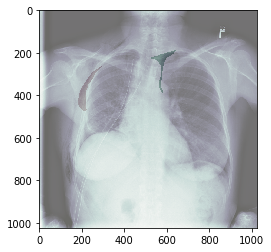

In [83]:
plt.imshow(plt.imread('../data/processed/train/%s.png'%_img_id), cmap=plt.cm.bone)
plt.imshow(rle2mask(_masks[0], 1024, 1024), alpha=0.25, cmap='Reds')
plt.imshow(rle2mask(_masks[1], 1024, 1024), alpha=0.25, cmap='Greens')